# Explore & Visualize the DataSet

In [100]:
import pandas as pd
import os
import time
from tqdm import tqdm
import re

# for Explore & Visualize
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from nltk import pos_tag
from wordcloud import WordCloud

# for preprocessing data
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from nltk.tokenize import word_tokenize

# for building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import pickle

In [2]:
csv_path = r"/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
df = pd.read_table(csv_path, sep="|")
df.head(9)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .


In [3]:
new_columns = {
    " comment_number" : "comment_number",
    " comment" : "comment"
}
df = df.rename(columns=new_columns)

In [4]:
grouped_data = df.groupby('image_name')['comment'].apply(lambda group: group.values.tolist()).reset_index(name='comments')

In [5]:
grouped_data

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
31778,997338199.jpg,"[ Woman writing on a pad in room with gold , d..."
31779,997722733.jpg,[ A person in a red shirt climbing up a rock f...
31780,997876722.jpg,[ Two male construction workers are working on...
31781,99804383.jpg,[ An older busker in glasses plays an Eastern ...


In [6]:
# Prepare image_paths, and descriptions for the visualize_samples function
image_paths = ['/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/' + image_name for image_name in grouped_data['image_name']]
descriptions = grouped_data['comments']

In [7]:
def visualize_samples(image_paths, descriptions, num_samples=7):
    
    sampled_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))
    sampled_image_paths = [image_paths[i] for i in sampled_indices]
    sampled_descriptions = [descriptions[i] for i in sampled_indices]

    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 20))

    for i in range(num_samples):
        img_path = sampled_image_paths[i]
        description_list = [desc.split(' ', 1)[1] for desc in sampled_descriptions[i]]

        # Load and display image
        img = mpimg.imread(img_path)
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')

        # Display multiple descriptions as text
        axs[i, 1].text(0.5, 0.5, '\n'.join(description_list), fontsize=10, va='center', ha='center', wrap=True)
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

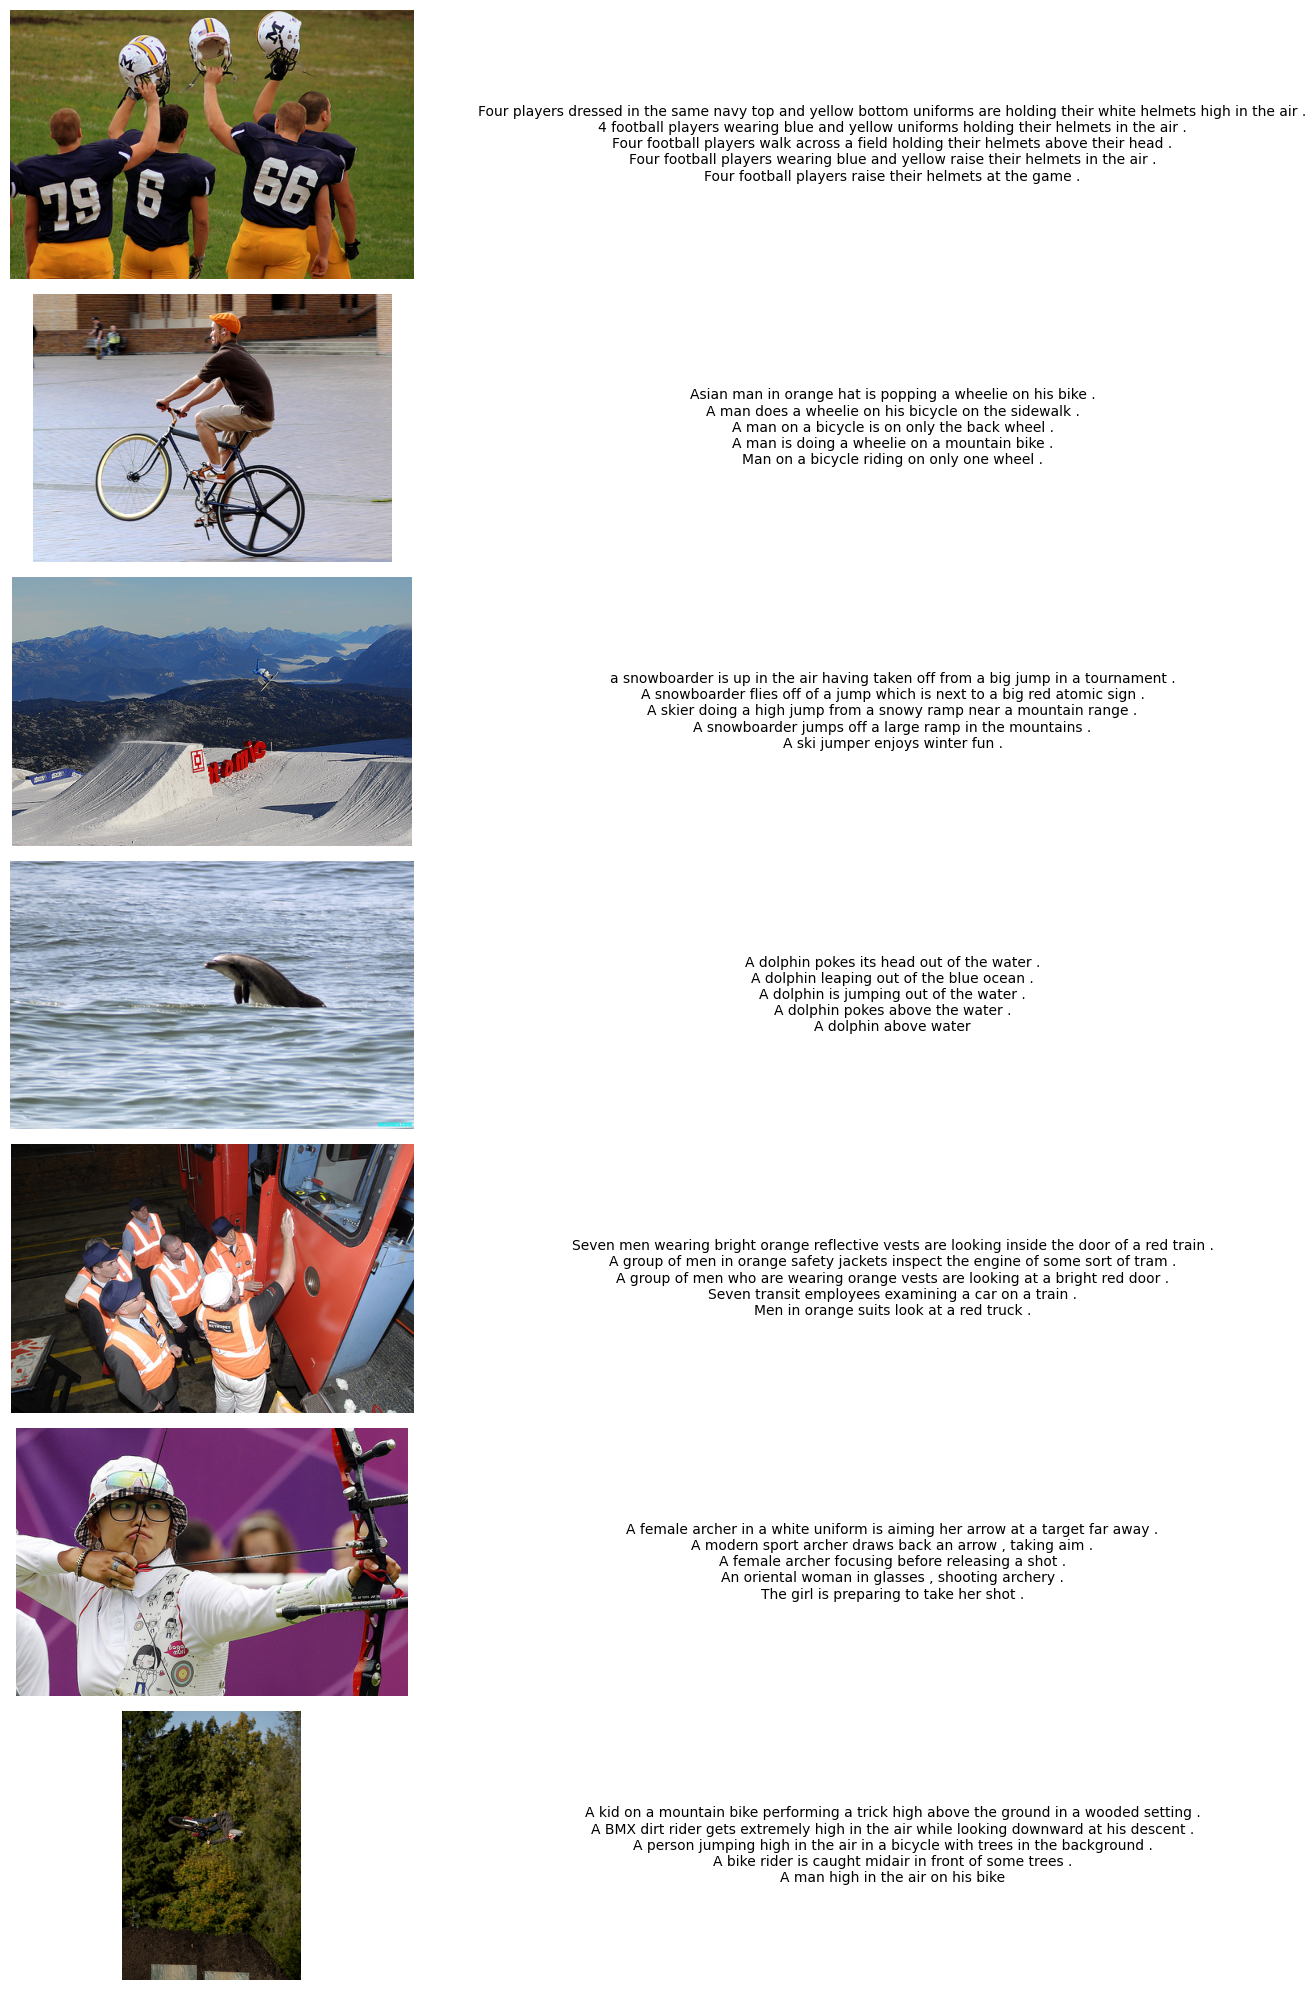

In [8]:
visualize_samples(image_paths, descriptions)

# exploratory data analysis (EDA)

### <span style="font-weight: bold; color: #007bff;">Basic Statistics:</apan>

Get basic statistics about the dataset, such as the number of unique images, comments, etc.

In [9]:
unique_images = df['image_name'].nunique()
unique_comments = df['comment'].nunique()
total_records = len(df)

print(f"Number of unique images: {unique_images}")
print(f"Number of unique comments: {unique_comments}")
print(f"Total number of records: {total_records}")

Number of unique images: 31783
Number of unique comments: 158438
Total number of records: 158915


### <span style="font-weight: bold; color: #007bff;">Distribution of Comments per Image:</span>

Visualize the distribution of comments per image to understand how many comments are typically associated with each image.

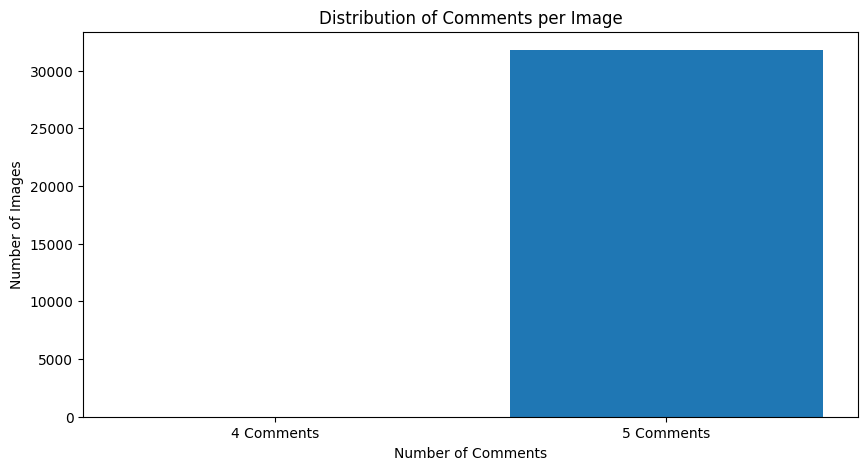

In [10]:
comments_per_image = df.groupby('image_name')['comment'].count()

images_with_4_comments = comments_per_image[comments_per_image == 4]
images_with_5_comments = comments_per_image[comments_per_image == 5]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar([3.5, 4.5], [len(images_with_4_comments), len(images_with_5_comments)], tick_label=['4 Comments', '5 Comments'])
plt.xlabel('Number of Comments')
plt.ylabel('Number of Images')
plt.title('Distribution of Comments per Image')
plt.show()

### <span style="font-weight: bold; color: #007bff;">Word Cloud:</span>

Generate a word cloud to visualize the most frequent words in the comments.

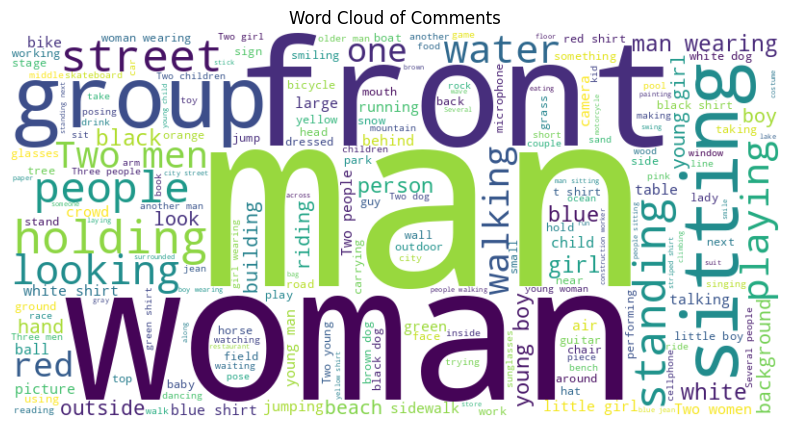

In [11]:
all_comments_text = ' '.join(df['comment'].fillna(''))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


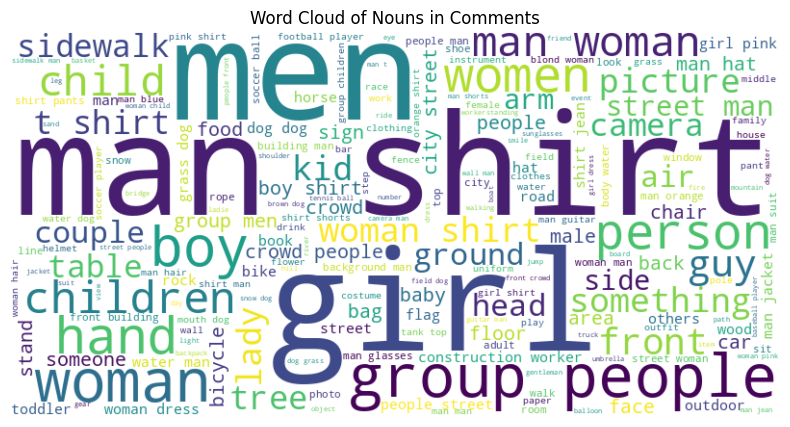

In [16]:
df['pos_tags'] = df['comment'].fillna("").apply(lambda x: pos_tag(word_tokenize(x.lower())))

nouns = [word[0] for tags in df['pos_tags'] for word in tags if word[1].startswith('NN')]

wordcloud_nouns = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nouns))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nouns, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Nouns in Comments')
plt.show()

### <span style="font-weight: bold; color: #007bff;">Caption Length Distribution:</span>

Analyze the distribution of caption lengths to understand the range of caption lengths in the dataset.

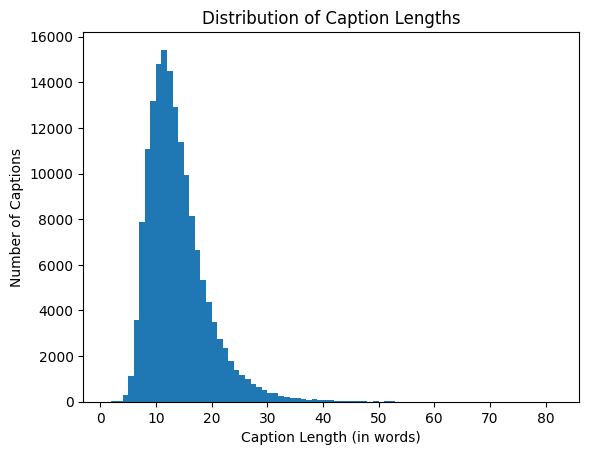

In [17]:
# Caption length distribution
df['caption_length'] = df['comment'].fillna('').apply(lambda x: len(x.split()))
plt.hist(df['caption_length'], bins=range(1, max(df['caption_length']) + 1))
plt.xlabel('Caption Length (in words)')
plt.ylabel('Number of Captions')
plt.title('Distribution of Caption Lengths')
plt.show()


# Data Pre-processing
### <span style="font-weight: bold; color: #007bff;">Deal with the nan value:</span>

In [18]:
df.isna().sum()

image_name        0
comment_number    0
comment           1
pos_tags          0
caption_length    0
dtype: int64

In [19]:
target_column = 'comment'
nan_indices = df[df[target_column].isna()]
nan_indices

,image_name,comment_number,comment,pos_tags,caption_length
19999,2199200615.jpg,4 A dog runs across the grass .,NaN,[],0


In [20]:
image_to_delete = '2199200615.jpg'
file_name_column = 'image_name'


index_to_delete = df[df[file_name_column] == image_to_delete].index
index_to_delete

Index([19995, 19996, 19997, 19998, 19999], dtype='int64')

In [21]:
df = df.drop(index_to_delete, axis=0)
df.reset_index(drop=True, inplace=True)

In [22]:
df.isna().sum()

image_name        0
comment_number    0
comment           0
pos_tags          0
caption_length    0
dtype: int64

In [23]:
# Extract images with 5 comments
images_with_5_comments = df.groupby('image_name').filter(lambda group: len(group) == 5)['image_name'].unique()

In [24]:
sample = '997338199.jpg'
('2199200615.jpg' in images_with_5_comments, sample in images_with_5_comments)

(False, True)

In [25]:
images_with_5_comments[:10]

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg',
       '1000344755.jpg', '1000366164.jpg', '1000523639.jpg',
       '1000919630.jpg', '10010052.jpg', '1001465944.jpg',
       '1001545525.jpg'], dtype=object)

In [26]:
df

,image_name,comment_number,comment,pos_tags,caption_length
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,"[(two, CD), (young, JJ), (guys, NNS), (with, I...",17
1,1000092795.jpg,1,"Two young , White males are outside near many...","[(two, CD), (young, JJ), (,, ,), (white, JJ), ...",11
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,"[(two, CD), (men, NNS), (in, IN), (green, JJ),...",11
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,"[(a, DT), (man, NN), (in, IN), (a, DT), (blue,...",11
4,1000092795.jpg,4,Two friends enjoy time spent together .,"[(two, CD), (friends, NNS), (enjoy, JJ), (time...",7
...,...,...,...,...,...
158905,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...,"[(a, DT), (man, NN), (in, IN), (shorts, NNS), ...",25
158906,998845445.jpg,1,"A young man hanging over the side of a boat ,...","[(a, DT), (young, JJ), (man, NN), (hanging, VB...",25
158907,998845445.jpg,2,A man is leaning off of the side of a blue an...,"[(a, DT), (man, NN), (is, VBZ), (leaning, VBG)...",23
158908,998845445.jpg,3,"A man riding a small boat in a harbor , with ...","[(a, DT), (man, NN), (riding, VBG), (a, DT), (...",18


___

### Extract Image Features (VGG16)

In [52]:
selected_df = grouped_data[grouped_data['image_name'].isin(images_with_5_comments[:10000])]
selected_df

,image_name,comments
0,1000092795.jpg,[ Two young guys with shaggy hair look at thei...
1,10002456.jpg,[ Several men in hard hats are operating a gia...
2,1000268201.jpg,[ A child in a pink dress is climbing up a set...
3,1000344755.jpg,[ Someone in a blue shirt and hat is standing ...
4,1000366164.jpg,"[ Two men , one in a gray shirt , one in a bla..."
...,...,...
9996,2952141476.jpg,[ A person is out in the water at the beach wh...
9997,295229746.jpg,[ A person in an apron is selling many differe...
9998,2952320230.jpg,[ The woman is dressed in all white swinging a...
9999,295258727.jpg,[ Two distant black dogs running across grass ...


In [28]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [29]:
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [30]:
# image_folder_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
# image_files = selected_df.image_name.values

# feature_dict = {}
# start_time = time.time()

# for image_file in tqdm(image_files, desc="Extracting Features", unit="image"):
#     image_path = os.path.join(image_folder_path, image_file)
#     img_array = load_and_preprocess_image(image_path)

#     features = model.predict(img_array, verbose=0)
    
#     img_id = image_file.split('.')[0]
#     feature_dict[img_id] = features

# end_time = time.time()

# total_time = end_time - start_time
# print(f"Total execution time: {total_time} seconds")

Extracting Features: 100%|██████████| 10000/10000 [1:14:18<00:00,  2.24image/s]

Total execution time: 4458.4834134578705 seconds


In [31]:
features_save_path = "/kaggle/working/features_dict.pkl"

In [32]:
# with open(features_save_path, 'wb') as file: # Save
#     pickle.dump(feature_dict, file)

In [33]:
with open(features_save_path, 'rb') as file: # Load
    loaded_features_dict = pickle.load(file)

# Text Processing

In [ ]:

def preprocessing_text(data):
    data['comments'] = data['comments'].apply(lambda x: [comment.lower() for comment in x])
    data['comments'] = data['comments'].apply(lambda x: [' '.join(re.sub(r'[^a-zA-Z\s]', ' ', word) for word in comment.split() if len(word) > 1) for comment in x])
    data['comments'] = data['comments'].apply(lambda x: ['startseq ' + comment + ' endseq' for comment in x])
    return data

In [54]:
data = preprocessing_text(selected_df)

/tmp/ipykernel_33/549680439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comments'] = data['comments'].apply(lambda x: [comment.lower() for comment in x])
/tmp/ipykernel_33/549680439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['comments'] = data['comments'].apply(lambda x: [' '.join(re.sub(r'[^a-zA-Z\s]', ' ', word) for word in comment.split() if len(word) > 1) for comment in x])
/tmp/ipykernel_33/549680439.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [58]:
data.comments.tolist()[-1]

['startseq man dressed in police uniform on segway personal transportation device is in the street endseq',
 'startseq security guard in blue shirt moving through an airport endseq',
 'startseq policeman rides segway past foreign exchange counter endseq',
 'startseq policeman is riding vehicle through building endseq',
 'startseq security wearing nice clothes endseq']

In [59]:
all_captions = []
for captions in data.comments:
    for caption in captions:
        all_captions.append(caption)

In [60]:
all_captions[:5]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

11127

In [62]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

In [64]:
image_ids = list(loaded_features_dict.keys())
split = int(len(image_ids) * 0.97)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def custom_data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    image_inputs, sequence_inputs, output_labels = [], [], []
    while True:
        for key in data_keys:
            captions_list = mapping[key]
            for caption in captions_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    input_seq, output_seq = sequence[:i], sequence[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    image_inputs.append(features[key][0])
                    sequence_inputs.append(input_seq)
                    output_labels.append(output_seq)
            
            if len(image_inputs) >= batch_size:
                yield [np.array(image_inputs), np.array(sequence_inputs)], np.array(output_labels)
                image_inputs, sequence_inputs, output_labels = [], [], []

# Building & Train the model

In [66]:
# Image feature layers
image_input = Input(shape=(4096,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence feature layers
sequence_input = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.4)(embedding_layer)
lstm_layer = LSTM(256)(sequence_dropout)


In [67]:
# Decoder model
merged_features = add([image_dense, lstm_layer])
decoder_dense1 = Dense(256, activation='relu')(merged_features)
output_layer = Dense(vocab_size, activation='softmax')(decoder_dense1)

In [68]:
# Combine the image and sequence inputs into the model
custom_model = Model(inputs=[image_input, sequence_input], outputs=output_layer)

In [69]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

In [72]:
mapping = dict(zip(loaded_features_dict.keys(), data.comments.values.tolist()))

In [73]:
# for i in range(epochs):
#     generator = custom_data_generator(train, mapping, loaded_features_dict, tokenizer, max_length, vocab_size, batch_size)
#     custom_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

303/303 [==============================] - 126s 415ms/step - loss: 2.0135 - accuracy: 0.4289


In [74]:
custom_model.save('/kaggle/working/model.h5') # Save

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
custom_model = load_model('/kaggle/working/model.h5') # Load

# Predict

In [75]:
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

In [ ]:
def generate_caption(model, image, tokenizer, max_length):
    generated_caption = 'startseq'
    initial_sequence = tokenizer.texts_to_sequences([generated_caption])[0]
    
    for _ in range(max_length):
        padded_sequence = pad_sequences([initial_sequence], max_length)
        predictions = model.predict([image, padded_sequence], verbose = 0)
        predicted_index = np.argmax(predictions)
        predicted_word = idx_to_word(predicted_index, tokenizer)

        if predicted_word is None:
            break
        
        generated_caption += " " + predicted_word
        
        if predicted_word == 'endseq':
            break

    return generated_caption

In [ ]:
def predict_caption(image_name, max_length):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = f"/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{image_name}"
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual'.center(90, "-"))

    for caption in captions:
        print(caption)
        
    # predict the caption
    y_pred = generate_caption(custom_model, loaded_features_dict[image_id], tokenizer, max_length)
    print('Predicted'.center(90, "-"))
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

------------------------------------------Actual------------------------------------------
startseq bride and groom walking side by side out of focus on pathway next to brick building endseq
startseq beautiful bride walking on sidewalk with her new husband endseq
startseq recently married couple pose for the camera endseq
startseq groom and bride are standing arm in arm endseq
startseq couple getting married endseq
----------------------------------------Predicted-----------------------------------------
startseq bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride bride


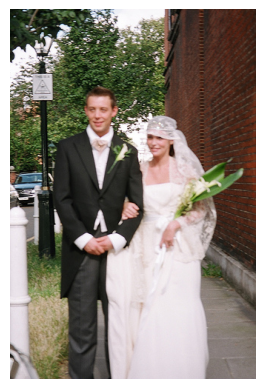

In [98]:
predict_caption("1011572216.jpg", 30)